# Daten importieren

In [ ]:
import pandas as pd

# Schritt 1: Lese die entsprechende Datei ein, speichere die Daten in der Variable 'df' ab und gib sie anschließend aus.
df = pd.read_csv("stock_prices_data.csv", parse_dates=["Date"], index_col="Date")
df = df.asfreq('D')
df

,Stock Price
Date,
2012-01-01,9.851750
2012-01-02,14.358194
2012-01-03,8.203045
2012-01-04,9.727762
2012-01-05,11.846368
...,...
2019-12-27,98.292739
2019-12-28,95.836428
2019-12-29,98.995890


# Daten visualisieren

<Axes: xlabel='Date', ylabel='Stock Price'>

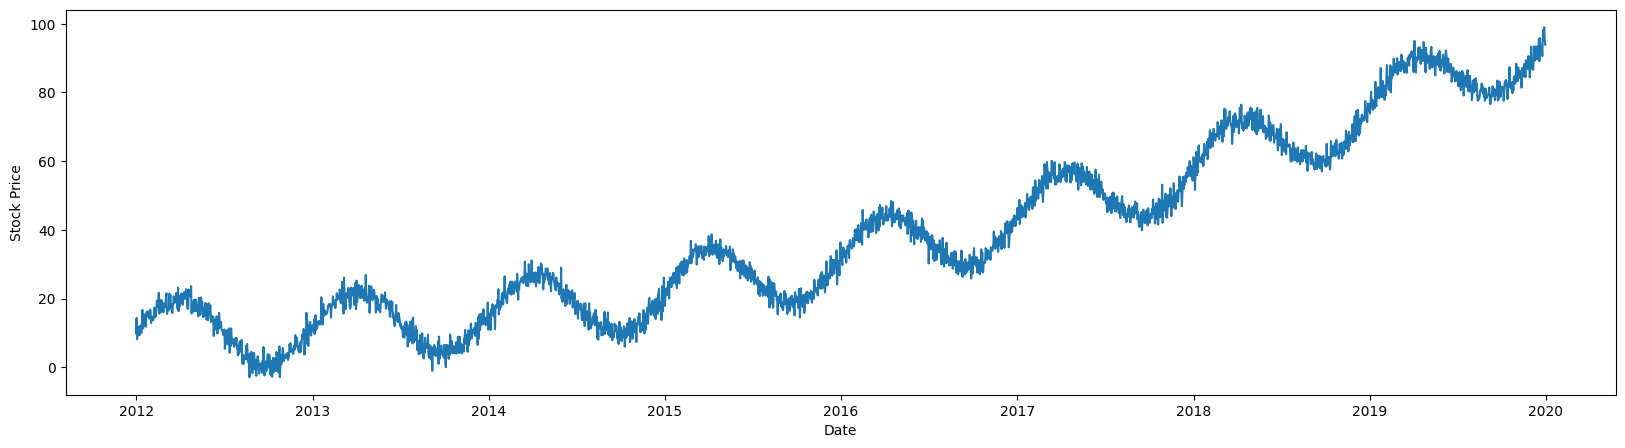

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Schritt 2: Visualisiere die Daten mithilfe eines Lineplots.
plt.figure(figsize=(20,5))
sns.lineplot(x=df.index, y=df["Stock Price"])

<Axes: xlabel='Date', ylabel='Stock Price'>

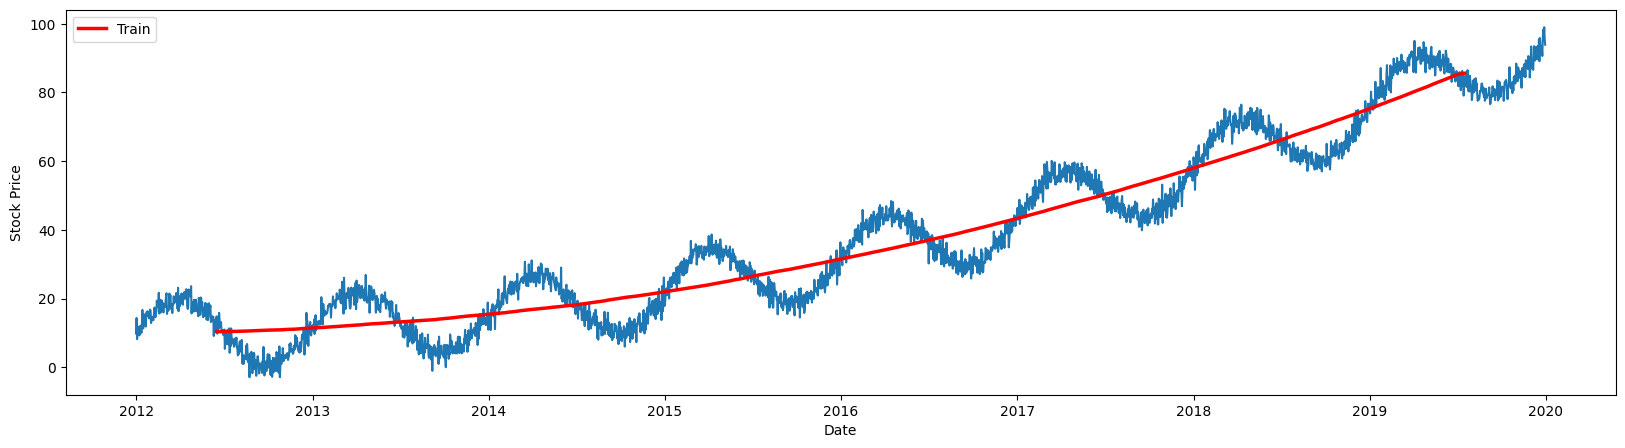

In [ ]:
# Schritt 3: Ermittle den gleitenden Durchschnitt über einen Zeitraum von 365 Tagen, wobei mindestens 350 Tage berücksichtigt werden müssen.
rolling_average_df = df.rolling(window=365, center=True, min_periods=350).mean()

# Schritt 4: Visualisiere die Daten und den gleitenden Durchschnitt jeweils mithilfe eines Lineplots, um den vorherrschenden Trend in den Daten zu identifizieren.
plt.figure(figsize=(20,5))
sns.lineplot(x=df.index, y=df["Stock Price"])
sns.lineplot(x=rolling_average_df.index, y=rolling_average_df["Stock Price"], color="red", linewidth=2.5, label="Train")

Text(0.5, 1.0, 'Weekly Plot')

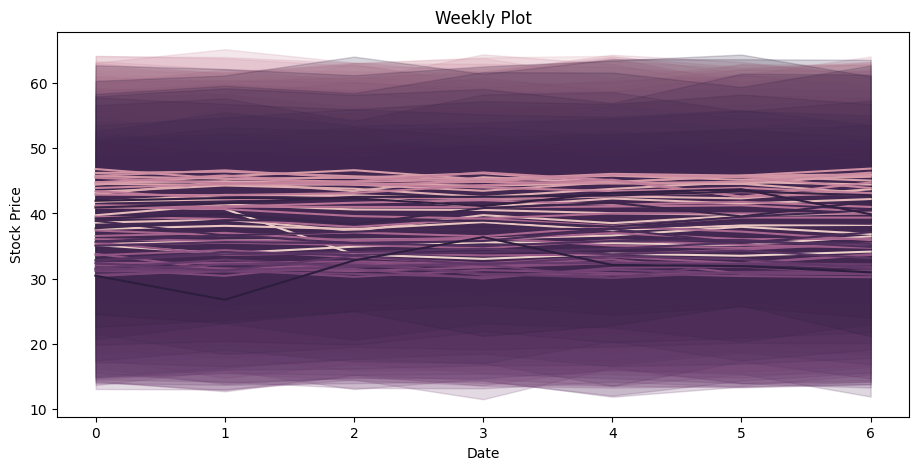

In [ ]:
# Schritt 5: Erstelle den 'Weekly Plot', um zu schauen, ob es eine Wöchentliche Säsonalität gibt.
plt.figure(figsize=(11, 5))
sns.lineplot(x=df.index.dayofweek, y=df["Stock Price"], hue=df.index.isocalendar().week.astype(int), legend=False)
plt.title("Weekly Plot")

# Daten aufteilen

In [ ]:
# Schritt 6: Unterteile die Daten in df_train und df_test, wobei df_train alle Daten bis 2018 enthält und df_test alle Daten ab 2018.
df_train = df[df.index.year < 2018]
df_test = df[df.index.year >= 2018]

In [ ]:
df_train

,Stock Price
Date,
2012-01-01,9.851750
2012-01-02,14.358194
2012-01-03,8.203045
2012-01-04,9.727762
2012-01-05,11.846368
...,...
2017-12-27,55.651526
2017-12-28,55.502433
2017-12-29,58.329776


In [ ]:
df_test

,Stock Price
Date,
2018-01-01,61.122599
2018-01-02,59.724579
2018-01-03,59.919369
2018-01-04,51.631389
2018-01-05,56.330096
...,...
2019-12-27,98.292739
2019-12-28,95.836428
2019-12-29,98.995890


# Besten Wert für *'order'* bestimmen

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
import numpy as np

def best_order_cv(orders, y_train):
    best_order = None
    best_score = float('inf')

    for order in orders:
        fourier = CalendarFourier(freq="Y", order=order)
        # Schritt 7: Bestimme basierend auf deiner Beobachtung aus Schritt 4, welchen Wert der 'order'-Parameter in 'DeterministicProcess' erhalten soll.
        dp = DeterministicProcess(index=y_train.index, order=2, additional_terms=[fourier])
        X_train = dp.in_sample()
        model = LinearRegression()
        scores = cross_val_score(model, X_train, y_train, cv=4, scoring="neg_mean_absolute_error")
        mean_score = -np.mean(scores)

        if mean_score < best_score:
            best_order = order
            best_score = mean_score

    return best_order

In [ ]:
# Schritt 8: Ermittle mit der Funktion 'best_order_cv()' den optimalen Wert für den 'order'-Parameter in 'CalendarFourier'.
result = best_order_cv([1, 2, 3, 5, 7], df_train["Stock Price"])
print("The best order is: ", result)

The best order is:  1


# Features generieren

In [ ]:
# Schritt 9: Generiere die entsprechenden Features basierend auf den Ergebnissen der vorherigen Schritte.
fourier = CalendarFourier(freq="Y", order=1)
dp = DeterministicProcess(index=df.index, order=2, additional_terms=[fourier])

X = dp.in_sample()
X

,trend,trend_squared,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
Date,,,,
2012-01-01,1.0,1.0,0.000000,1.000000
2012-01-02,2.0,4.0,0.017166,0.999853
2012-01-03,3.0,9.0,0.034328,0.999411
2012-01-04,4.0,16.0,0.051479,0.998674
2012-01-05,5.0,25.0,0.068615,0.997643
...,...,...,...,...
2019-12-27,2918.0,8514724.0,-0.085965,0.996298
2019-12-28,2919.0,8520561.0,-0.068802,0.997630
2019-12-29,2920.0,8526400.0,-0.051620,0.998667


In [ ]:
# Schritt 10: Teile die Features mithilfe von '.loc' in X_train und X_test auf.
X_train = X.loc[df_train.index]
X_test = X.loc[df_test.index]

In [ ]:
y_train = df_train["Stock Price"]
y_test = df_test["Stock Price"]

# Modell trainieren

In [ ]:
from sklearn.linear_model import LinearRegression

# Schritt 11: Erstelle eine Instanz eines linearen Regressionsmodells und trainiere dieses Modell auf den Trainingsdaten.
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

# Modell visualisieren

In [ ]:
# Schritt 12: Nutze das trainierte Modell, um Vorhersagen für die Trainingsdaten zu generieren.
train_predictions = model.predict(X_train)

<Axes: xlabel='Date', ylabel='Stock Price'>

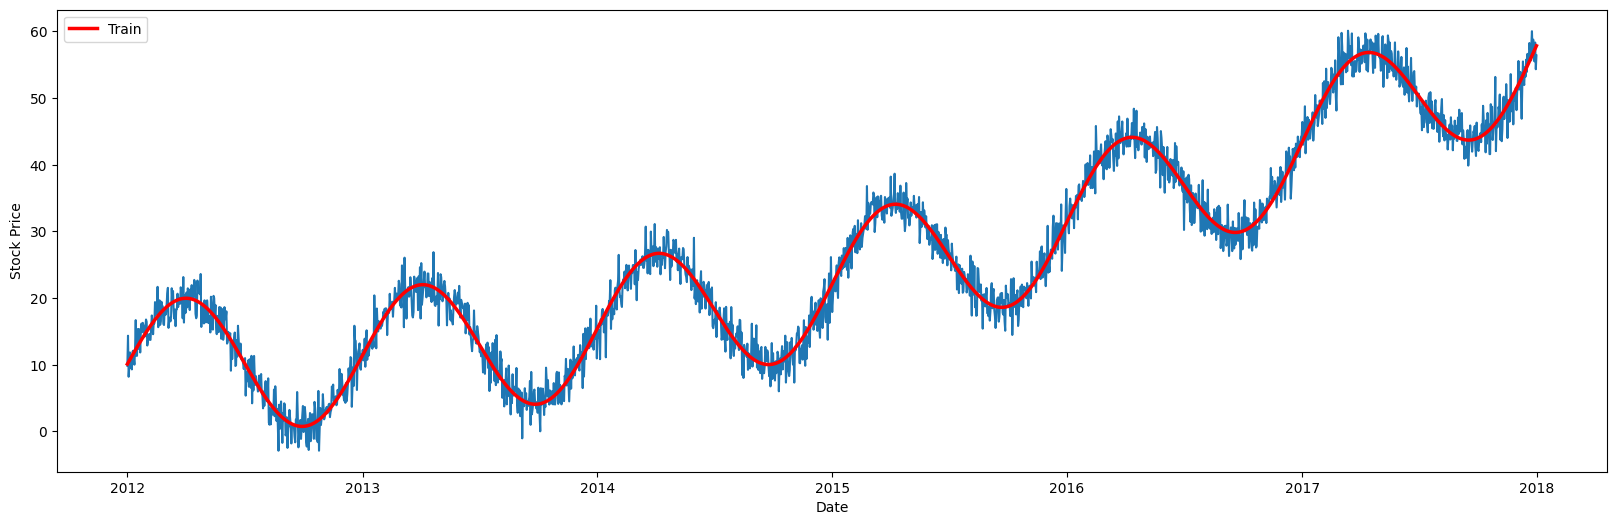

In [ ]:
# Schritt 13: Visualisiere die Trainingsdaten und das Modell jeweils mit einem Lineplot.
plt.figure(figsize=(20, 6))
sns.lineplot(x=X_train.index, y=y_train)
sns.lineplot(x=X_train.index, y=train_predictions, color="red", linewidth=2.5, label="Train")

# Vorhersage auf den Testdaten

In [ ]:
# Schritt 14: Nutze das trainierte Modell, um Vorhersagen für die Testdaten zu generieren.
test_predictions = model.predict(X_test)

# Modellbewertung (Mean Absolute Error)

In [ ]:
from sklearn.metrics import mean_absolute_error

# Schritt 15: Berechne den Mean Absolute Error (MAE) basierend auf den Vorhersagen und den Testdaten.
mae = mean_absolute_error(test_predictions, y_test)
print("Mean Absolute Error:", mae)

Mean Absolute Error: 1.627209511423028


<Axes: xlabel='Date', ylabel='Stock Price'>

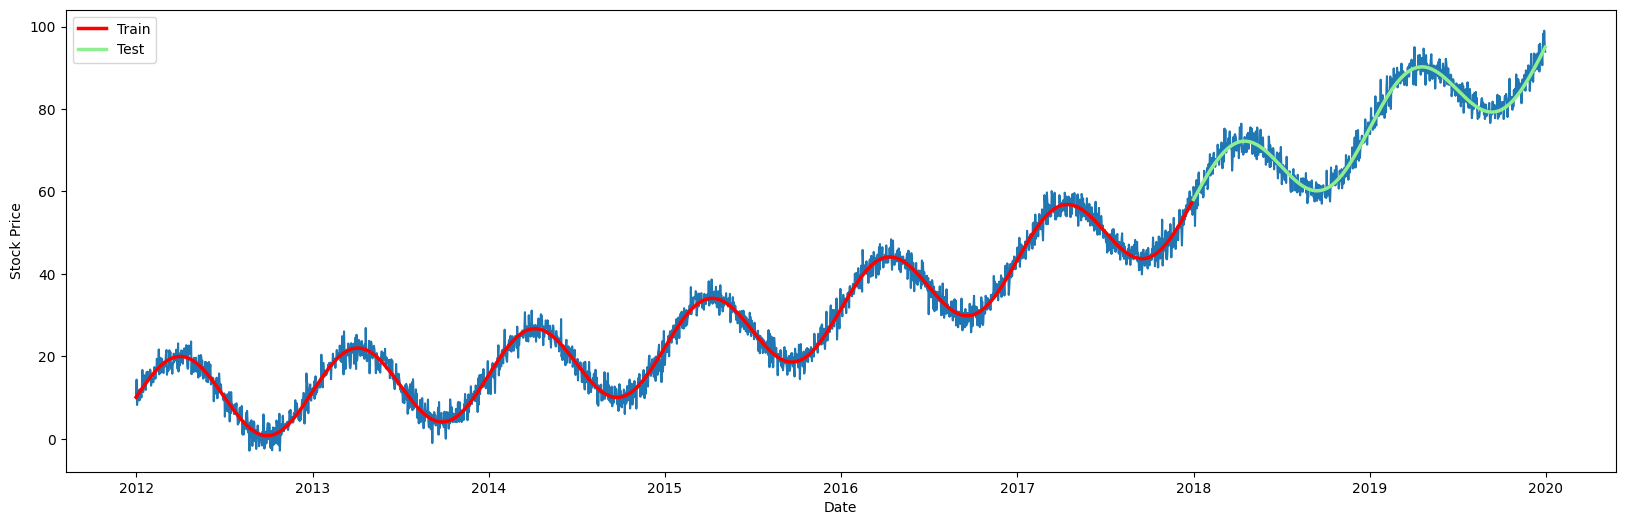

In [ ]:
# Schritt 16: Visualisiere die gesamten Daten, das Modell und die Vorhersagen für die Testdaten jeweils mit einem Lineplot.
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index, y=df["Stock Price"])
sns.lineplot(x=X_train.index, y=train_predictions, color="red", linewidth=2.5, label="Train")
sns.lineplot(x=X_test.index, y=test_predictions, color="lightgreen", linewidth=2.5, label="Test")

# Prognosen für die nächsten drei Jahre:

In [ ]:
# Schritt 17: Erstelle die erforderlichen Features, um Prognosen für die nächsten drei Jahre zu machen.
X_forecast = dp.out_of_sample(steps=1095)
X_forecast

,trend,trend_squared,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)"
2020-01-01,2923.0,8543929.0,0.000000,1.000000
2020-01-02,2924.0,8549776.0,0.017166,0.999853
2020-01-03,2925.0,8555625.0,0.034328,0.999411
2020-01-04,2926.0,8561476.0,0.051479,0.998674
2020-01-05,2927.0,8567329.0,0.068615,0.997643
...,...,...,...,...
2022-12-26,4013.0,16104169.0,-0.103102,0.994671
2022-12-27,4014.0,16112196.0,-0.085965,0.996298
2022-12-28,4015.0,16120225.0,-0.068802,0.997630
2022-12-29,4016.0,16128256.0,-0.051620,0.998667


In [ ]:
# Schritt 18: Nutze das trainierte Modell, um Vorhersagen für die X_forecast zu generieren.
forecast_predictions = model.predict(X_forecast)

<Axes: xlabel='Date', ylabel='Stock Price'>

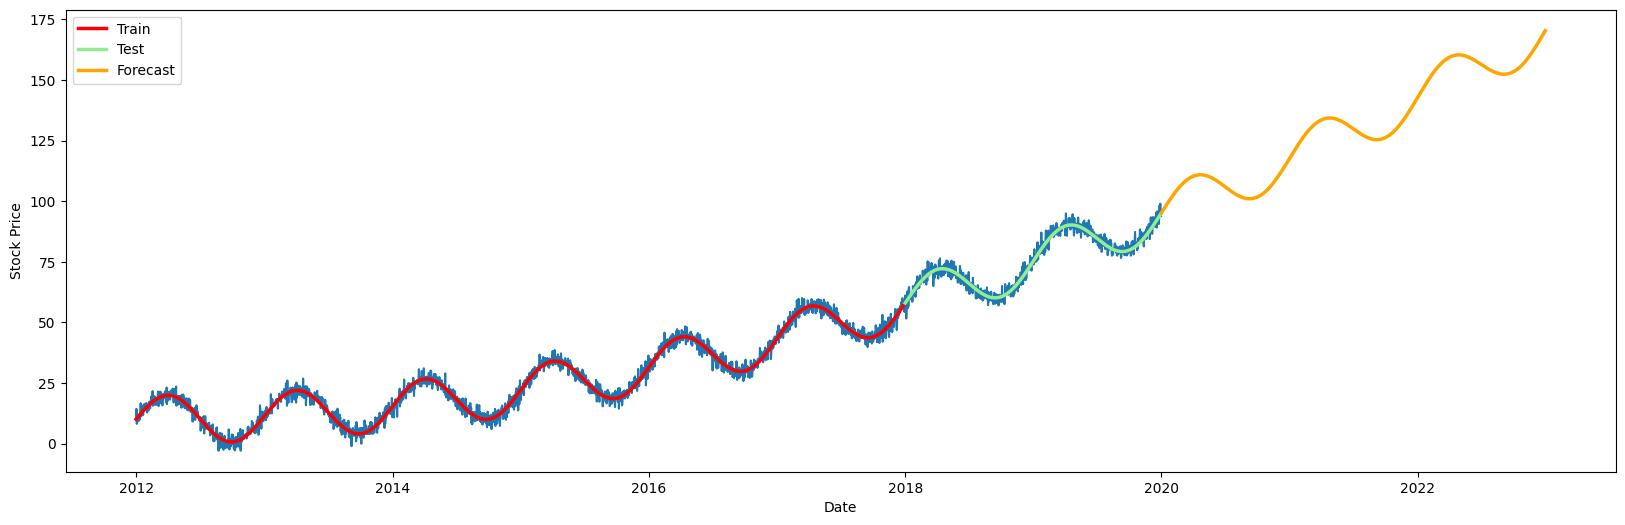

In [ ]:
# Schritt 19: Ergänze zu den Plots aus Schritt 16 einen weiteren Linienplot, um die Prognosen zu visualisieren.
plt.figure(figsize=(20, 6))
sns.lineplot(x=df.index, y=df["Stock Price"])
sns.lineplot(x=X_train.index, y=train_predictions, color="red", linewidth=2.5, label="Train")
sns.lineplot(x=X_test.index, y=test_predictions, color="lightgreen", linewidth=2.5, label="Test")
sns.lineplot(x=X_forecast.index, y=forecast_predictions, color="orange", linewidth=2.5, label="Forecast")